In [1]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load dataset
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'
df = pd.read_csv(url)

# Normalize column names and text
df.columns = df.columns.str.lower().str.replace(' ', '_')
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# Fill missing values
target = 'converted'
categorical = df.select_dtypes(include=['object']).columns.tolist()
numerical = [c for c in df.select_dtypes(include=[np.number]).columns.tolist() if c != target]
df_prep = df.copy()
for c in categorical:
    df_prep[c] = df_prep[c].fillna('NA')
for c in numerical:
    df_prep[c] = df_prep[c].fillna(0.0)

# Split: 60/20/20 with random_state=1
X = df_prep.drop(columns=[target]).reset_index(drop=True)
y = df_prep[target].astype(int).reset_index(drop=True)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

print("Sizes: train, val, test =", X_train.shape[0], X_val.shape[0], X_test.shape[0])


Sizes: train, val, test = 877 292 293


In [2]:

# Q1: ROC AUC feature importance for numerical variables
aucs = {}
for col in numerical:
    scores = X_train[col].values
    auc = roc_auc_score(y_train, scores)
    if auc < 0.5:
        auc = roc_auc_score(y_train, -scores)
    aucs[col] = auc

print("AUC scores (train):")
for k, v in aucs.items():
    print(f"{k}: {v:.3f}")

best_feature = max(aucs, key=aucs.get)
print("\nQ1 — Highest AUC feature:", best_feature)


AUC scores (train):
number_of_courses_viewed: 0.765
annual_income: 0.555
interaction_count: 0.723
lead_score: 0.611

Q1 — Highest AUC feature: number_of_courses_viewed


In [3]:

# Q2: Train logistic regression with one-hot encoding (DictVectorizer)
dv = DictVectorizer(sparse=False)
X_train_enc = dv.fit_transform(X_train.to_dict(orient='records'))
X_val_enc = dv.transform(X_val.to_dict(orient='records'))

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train_enc, y_train)

y_val_pred = model.predict_proba(X_val_enc)[:,1]
auc_val = roc_auc_score(y_val, y_val_pred)

print("Q2 — Validation AUC:", round(auc_val, 3))


Q2 — Validation AUC: 0.866


Q3 — Threshold where precision ≈ recall: 0.62


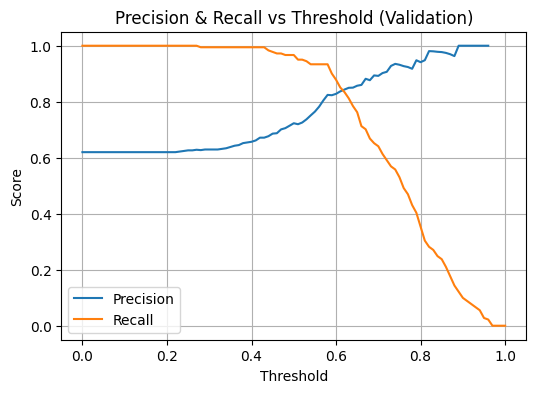

In [4]:
# Q3: Precision and Recall vs threshold
thresholds = np.linspace(0, 1, 101)
precisions, recalls = [], []

for thr in thresholds:
    preds = (y_val_pred >= thr).astype(int)
    if np.sum(preds) > 0: # Only calculate precision if there are positive predictions
        precisions.append(precision_score(y_val, preds))
    else:
        precisions.append(np.nan) # Append NaN if no positive predictions

    recalls.append(recall_score(y_val, preds))

# Find intersection point (excluding NaN values for precision)
precisions_no_nan = np.array(precisions)
recalls_no_nan = np.array(recalls)[~np.isnan(precisions_no_nan)]
thresholds_no_nan = thresholds[~np.isnan(precisions_no_nan)]
precisions_no_nan = precisions_no_nan[~np.isnan(precisions_no_nan)]


diffs = np.abs(precisions_no_nan - recalls_no_nan)
thr_intersect = thresholds_no_nan[np.argmin(diffs)]
print("Q3 — Threshold where precision ≈ recall:", round(thr_intersect, 3))


plt.figure(figsize=(6,4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.title('Precision & Recall vs Threshold (Validation)')
plt.grid(True)
plt.show()

Q4 — Threshold with max F1: 0.58


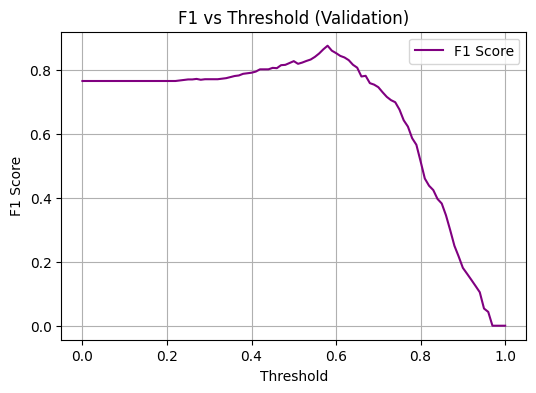

In [5]:

# Q4: F1 vs threshold
f1s = []
for thr in thresholds:
    preds = (y_val_pred >= thr).astype(int)
    f1s.append(f1_score(y_val, preds, zero_division=0))

thr_max_f1 = thresholds[np.argmax(f1s)]
print("Q4 — Threshold with max F1:", round(thr_max_f1, 3))
plt.figure(figsize=(6,4))
plt.plot(thresholds, f1s, label='F1 Score', color='purple')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 vs Threshold (Validation)')
plt.grid(True)
plt.legend()
plt.show()


In [6]:

# Q5: 5-Fold CV AUC scores and standard deviation
df_full_train = pd.concat([X_train, X_val]).reset_index(drop=True)
y_full_train = pd.concat([y_train, y_val]).reset_index(drop=True)

kf = KFold(n_splits=5, shuffle=True, random_state=1)
aucs_cv = []

for train_idx, val_idx in kf.split(df_full_train):
    Xtr = df_full_train.iloc[train_idx].to_dict(orient='records')
    Xv = df_full_train.iloc[val_idx].to_dict(orient='records')
    ytr = y_full_train.iloc[train_idx]
    yv = y_full_train.iloc[val_idx]

    Xtr_enc = dv.fit_transform(Xtr)
    Xv_enc = dv.transform(Xv)

    m = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    m.fit(Xtr_enc, ytr)
    yv_pred = m.predict_proba(Xv_enc)[:,1]
    aucs_cv.append(roc_auc_score(yv, yv_pred))

print("Q5 — AUCs:", [round(x,3) for x in aucs_cv])
print("Q5 — Std of scores:", round(np.std(aucs_cv), 3))


Q5 — AUCs: [0.82, 0.837, 0.876, 0.811, 0.784]
Q5 — Std of scores: 0.031


In [7]:

# Q6: Hyperparameter tuning with 5-Fold CV
Cs = [0.000001, 0.001, 1]
results = {}

for C in Cs:
    aucs = []
    for train_idx, val_idx in kf.split(df_full_train):
        Xtr = df_full_train.iloc[train_idx].to_dict(orient='records')
        Xv = df_full_train.iloc[val_idx].to_dict(orient='records')
        ytr = y_full_train.iloc[train_idx]
        yv = y_full_train.iloc[val_idx]

        Xtr_enc = dv.fit_transform(Xtr)
        Xv_enc = dv.transform(Xv)

        m = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        m.fit(Xtr_enc, ytr)
        yv_pred = m.predict_proba(Xv_enc)[:,1]
        aucs.append(roc_auc_score(yv, yv_pred))
    results[C] = (np.mean(aucs), np.std(aucs))

print("Q6 — Results (mean, std):")
for C, (mean, std) in results.items():
    print(f"C={C}: mean={round(mean,3)}, std={round(std,3)}")

best_mean = max([v[0] for v in results.values()])
candidates = [C for C,(mean,std) in results.items() if mean == best_mean]
if len(candidates) > 1:
    stds = {C: results[C][1] for C in candidates}
    best_C = min(stds, key=stds.get)
else:
    best_C = candidates[0]

print("\nQ6 — Best C:", best_C)


Q6 — Results (mean, std):
C=1e-06: mean=0.553, std=0.014
C=0.001: mean=0.867, std=0.019
C=1: mean=0.826, std=0.031

Q6 — Best C: 0.001
